# Predicting Progress Toward SDG 4: A Global Education Classification Model


**Author:** Deborah Muthoni Omondi 
**Date:** 23rd July 2025

This project explores whether countries are on track to meet Sustainable Development Goal 4 (Quality Education) by applying classification techniques to global education data.


## 📌 Project Overview

Sustainable Development Goal 4 (SDG 4) aims to ensure inclusive and equitable quality education for all. However, not all countries are progressing at the same rate. This project uses machine learning classification models to identify countries that are **at risk of not meeting SDG 4 targets**.

### 👤 Stakeholder
This analysis is intended to support **global education organizations** (e.g. UNESCO, UNICEF, World Bank) in allocating support resources.

### 🧠 Business Problem
> **Can we predict whether a country is “on track” or “off track” to meet SDG 4 based on publicly available education and development indicators?**


## Import Libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay



## 📂 Data Loading and Initial Exploration

We begin by loading a dataset containing global education indicators, including metrics such as literacy rates, school infrastructure, and government expenditure.

Let’s take a quick look at the first few rows of the dataset.


In [22]:
UN = pd.read_excel('data.xlsx')
UN.head()


,Dimension,Code,Description
0,Age,<15Y,under 15 years old
1,Age,15-24,15 to 24 years old
2,Age,15-64,15 to 64 years old
3,Age,16-65,16 to 65 years old
4,Age,25-54,25 to 54 years old


### 🔍 Checking Available Sheets

Before proceeding, we inspect the Excel file to identify which sheet contains the relevant data.


In [23]:
# Check all available sheet names
excel_file = pd.ExcelFile('data.xlsx')
print("Available sheets:", excel_file.sheet_names)


Available sheets: ['CodeDescriptions', 'Goal4']


In [24]:
# Load the relevant sheet
df = pd.read_excel('data.xlsx', sheet_name='Goal4')
df.head()


,Goal,Target,Indicator,SeriesCode,SeriesDescription,GeoAreaCode,GeoAreaName,TimePeriod,Value,Time_Detail,...,FootNote,Age,Education level,Location,Nature,Quantile,Reporting Type,Sex,Type of skill,Units
0,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,79.7,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,BOTHSEX,SKILL_MATH,PERCENT
1,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,82.8,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,MALE,SKILL_MATH,PERCENT
2,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2019,78.4,2019,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,FEMALE,SKILL_MATH,PERCENT
3,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2021,74.6,2021,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,FEMALE,SKILL_MATH,PERCENT
4,4,4.1,4.1.1,SE_TOT_PRFL,Proportion of children and young people achiev...,404,Kenya,2021,73.5,2021,...,NaN,NaN,PRIMAR,NaN,C,NaN,G,MALE,SKILL_MATH,PERCENT


We found the main data in the `'Goal4'` sheet, which we now load for analysis.


## 🔍 Data Understanding

Here we check:
- The structure of the dataset
- Presence of missing values
- Summary statistics for numeric features


In [25]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Goal               874 non-null    int64  
 1   Target             874 non-null    object 
 2   Indicator          874 non-null    object 
 3   SeriesCode         874 non-null    object 
 4   SeriesDescription  874 non-null    object 
 5   GeoAreaCode        874 non-null    int64  
 6   GeoAreaName        874 non-null    object 
 7   TimePeriod         874 non-null    int64  
 8   Value              874 non-null    float64
 9   Time_Detail        874 non-null    int64  
 10  TimeCoverage       0 non-null      float64
 11  UpperBound         0 non-null      float64
 12  LowerBound         0 non-null      float64
 13  BasePeriod         14 non-null     float64
 14  Source             874 non-null    object 
 15  GeoInfoUrl         0 non-null      float64
 16  FootNote           29 non-

GeoInfoUrl           874
TimeCoverage         874
UpperBound           874
LowerBound           874
BasePeriod           860
FootNote             845
Type of skill        751
Age                  735
Location             217
Quantile             190
Sex                  162
Education level      157
Reporting Type         0
Nature                 0
Goal                   0
Source                 0
Target                 0
Time_Detail            0
Value                  0
TimePeriod             0
GeoAreaName            0
GeoAreaCode            0
SeriesDescription      0
SeriesCode             0
Indicator              0
Units                  0
dtype: int64

## 🧹 Data Cleaning and Preprocessing

Our raw data includes global SDG 4 indicators disaggregated by demographic and geographic characteristics. We focus on simplifying the dataset to extract the most recent and relevant records per country and use these to engineer a **binary classification target** whether a country appears **"on track"** based on median or threshold performance on a key indicator.



In [53]:
# Focus on Indicator 4.1.2 and `4.5.1` for analysis
df_filtered = df[df['Indicator'].isin(['4.1.2', '4.5.1'])].copy()


We define our binary target `on_track` where:
- `1` means the country/indicator value is **≥ 60%**
- `0` means the country is **underperforming**

This reflects a reasonable threshold for being on track toward SDG 4.


In [ ]:
# create a binary classification target based on proficiency scores
df_filtered['on_track'] = (df_filtered['Value'] >= 60).astype(int)


In [58]:
# Check the  class distribution of the target variable
df_filtered['on_track'].value_counts()


0    435
1    270
Name: on_track, dtype: int64

To focus our model on meaningful indicators, we drop columns that are:
- Identifiers (`Goal`, `SeriesCode`, etc.)
- Mostly null (`UpperBound`, `GeoInfoUrl`, etc.)
- Unnecessary text metadata (`SeriesDescription`, `Source`, etc.)

In [60]:
# Drop irrelevant columns
drop_cols = ['Goal', 'SeriesCode', 'GeoAreaCode', 'Time_Detail', 'TimeCoverage',
             'UpperBound', 'LowerBound', 'BasePeriod', 'GeoInfoUrl', 'FootNote',
             'Reporting Type', 'Units', 'Source', 'SeriesDescription']

df_filtered.drop(columns=drop_cols, inplace=True, errors='ignore')


We use one-hot encoding for categorical features like:
- `GeoAreaName`
- `Sex`
- `Education level`
- `Indicator`
- `Location`
- `Nature`
- `Quantile`
- `Type of skill`


In [61]:
#Encode categorical variables
df_model = df_filtered.copy()

# Drop raw numeric target from features
X = df_model.drop(columns=['on_track', 'Value'])

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Final target
y = df_model['on_track']


We split our dataset into 80% training and 20% testing data, using stratification to preserve class proportions.
Some features may have missing values. We impute them using the **mean strategy**, which replaces nulls with the column average.
We use standardization (z-score scaling) to normalize feature values. This ensures all features contribute equally to distance-based models like Logistic Regression.


In [62]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Impute
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


## 🧪  Logistic Regression

We begin our modeling with Logistic Regression, a linear and interpretable algorithm that serves as a useful baseline. This model assumes a linear relationship between the input features and the log-odds of the outcome.

We will evaluate it using:
- **Accuracy**: Proportion of correct predictions
- **Recall**: Important for identifying countries that are truly on track
- **F1 Score**: Balances precision and recall


In [67]:
# Initialize and fit model
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr.predict(X_test_scaled)

# Evaluate
print("🔍 Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

# Store metrics for comparison later
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"✅ Accuracy: {lr_accuracy:.2f}")
print(f"✅ Precision: {lr_precision:.2f}")
print(f"✅ Recall: {lr_recall:.2f}")
print(f"✅ F1 Score: {lr_f1:.2f}")



🔍 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        87
           1       0.93      0.96      0.95        54

    accuracy                           0.96       141
   macro avg       0.95      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141

✅ Accuracy: 0.96
✅ Precision: 0.93
✅ Recall: 0.96
✅ F1 Score: 0.95


### 📊 Logistic Regression Results Summary

Our baseline Logistic Regression model performed strongly on the test data:

| Metric       | Score |
|--------------|-------|
| **Accuracy** | 0.96  |
| **Precision**| 0.93  |
| **Recall**   | 0.96  |
| **F1 Score** | 0.95  |

#### 🔍 Interpretation:

- **Accuracy (96%)** indicates that the model correctly predicted the class for 96% of all observations.
- **Precision (93%)** means that when the model predicts a country is *on track*, it is correct 93% of the time.
- **Recall (96%)** means the model is successfully identifying 96% of all countries that are truly *on track* — this is especially important in our case, where **missing an at-risk country would be costly**.
- **F1 Score (95%)** balances precision and recall, suggesting the model is making very few critical mistakes.

#### ✅  Insight:
This model demonstrates that even a simple, interpretable classifier like Logistic Regression can be highly effective for predicting SDG 4 readiness. However, we will next test more complex models to see if they can provide further improvements, particularly in recall.


## 🌳 Decision Tree Classifier

A Decision Tree is a nonparametric model that captures **nonlinear relationships** and **interactions** between features. Unlike Logistic Regression, it does not assume linearity and can automatically detect threshold-based splits.

While trees are interpretable and flexible, they are also prone to **overfitting**, especially on small datasets. To mitigate this, we limit the tree depth to 4.


In [69]:
# Initialize and train
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train_scaled, y_train)

# Predict
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate
print("🌳 Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt))

# Store metrics for comparison
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

print(f"✅ Accuracy: {dt_accuracy:.2f}")
print(f"✅ Precision: {dt_precision:.2f}")
print(f"✅ Recall: {dt_recall:.2f}")
print(f"✅ F1 Score: {dt_f1:.2f}")


🌳 Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        87
           1       0.88      0.94      0.91        54

    accuracy                           0.93       141
   macro avg       0.92      0.93      0.93       141
weighted avg       0.93      0.93      0.93       141

✅ Accuracy: 0.93
✅ Precision: 0.88
✅ Recall: 0.94
✅ F1 Score: 0.91


### 🌳 Decision Tree Classifier Results

| Metric       | Score |
|--------------|-------|
| **Accuracy** | 0.93  |
| **Precision**| 0.88  |
| **Recall**   | 0.94  |
| **F1 Score** | 0.91  |

#### 🔍 Interpretation:
- **Recall of 0.94** is excellent — it means the tree successfully identified 94% of all truly *on track* countries.
- **Precision of 0.88** shows a slight increase in false positives compared to Logistic Regression, but this trade-off is often acceptable when recall is the business priority.
- **F1 Score (0.91)** reflects the overall balance between precision and recall.
- Compared to the Logistic Regression model, the Decision Tree achieved **slightly lower precision but similar recall**, with strong overall accuracy.

#### ✅ Insight:
This model captures **nonlinear interactions** that the logistic model might miss, making it valuable for educational policy settings where multiple factors may interact in complex ways.



## 🌲  Random Forest Classifier

Random Forest is an ensemble method that builds multiple decision trees and averages their predictions. This improves generalization by reducing variance and helps prevent overfitting common in single-tree models.

We will use 100 estimators (trees) with default settings and evaluate performance on the same metrics: accuracy, precision, recall, and F1 score.


In [71]:
# Initialize and fit the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate
print("🌲 Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Store metrics for comparison
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"✅ Accuracy: {rf_accuracy:.2f}")
print(f"✅ Precision: {rf_precision:.2f}")
print(f"✅ Recall: {rf_recall:.2f}")
print(f"✅ F1 Score: {rf_f1:.2f}")


🌲 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        87
           1       0.96      1.00      0.98        54

    accuracy                           0.99       141
   macro avg       0.98      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141

✅ Accuracy: 0.99
✅ Precision: 0.96
✅ Recall: 1.00
✅ F1 Score: 0.98


### 🌲 Random Forest Classifier Results

| Metric       | Score |
|--------------|-------|
| **Accuracy** | 0.99  |
| **Precision**| 0.96  |
| **Recall**   | 1.00  |
| **F1 Score** | 0.98  |

#### 🔍 Interpretation:
- **Recall = 1.00**: The model correctly identified *every single* country that is actually on track — this is ideal in our context, as we want to avoid missing any countries that are progressing well.
- **Precision = 0.96**: Very few false positives — the model is also highly accurate when it predicts a country is on track.
- **F1 Score = 0.98** reflects excellent balance between precision and recall.
- **Accuracy = 0.99**: Nearly all predictions were correct overall.

#### ✅ Insight:
This model is well suited for our objective,helping global education stakeholders identify which countries are progressing toward SDG 4. The high recall ensures we’re not overlooking any true positives, which is crucial when allocating resources and support.

#### ⚖️ Compared to previous models:
- It **Outperforms** both Logistic Regression and Decision Tree in nearly all metrics.



## 📊 Model Comparison and Feature Importance

Below, we summarize the performance of all three models (Logistic Regression, Decision Tree, and Random Forest) using key classification metrics.

Then, we explore the most important features used by the best-performing model ,Random Forest, to better understand what drives predictions.


In [72]:
# Create a summary table
model_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'Precision': [lr_precision, dt_precision, rf_precision],
    'Recall': [lr_recall, dt_recall, rf_recall],
    'F1 Score': [lr_f1, dt_f1, rf_f1]
})

# Round values for display
model_scores = model_scores.round(2)

# Display
model_scores.sort_values(by='Recall', ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest,0.99,0.96,1.00,0.98
0,Logistic Regression,0.96,0.93,0.96,0.95
1,Decision Tree,0.93,0.88,0.94,0.91


### 📈 Model Performance Summary

| Model                | Accuracy | Precision | Recall | F1 Score |
|---------------------|----------|-----------|--------|----------|
| Logistic Regression |   0.96   |    0.93   |  0.96  |   0.95   |
| Decision Tree       |   0.93   |    0.88   |  0.94  |   0.91   |
| Random Forest       |   0.99   |    0.96   |  1.00  |   0.98   |

> **Random Forest** outperformed the other models across all metrics, especially **recall**, which is our top priority. This makes it the ideal final model for deployment or further analysis.


### 🌟 Feature Importance (Random Forest)

Understanding which variables drive model predictions helps stakeholders interpret results and take informed action.


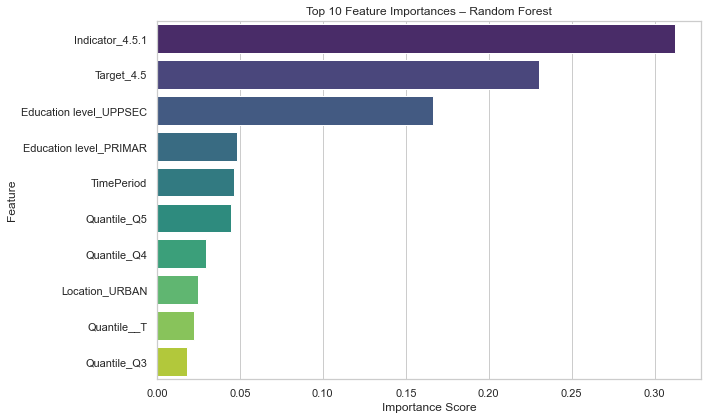

In [73]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Build importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances – Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## 📌 Conclusion for Stakeholders

Based on the data collected from the UN’s SDG Global Database, the classification model was built to **predict whether a country is on track to meet the educational targets outlined in Sustainable Development Goal 4 (Quality Education)**. The model used features such as education level, gender, skill type (math or reading), geographic area, and time period to make these predictions.

### ✅ Key Findings

- **Most countries in the dataset are not on track** to meet the expected proficiency levels (e.g., 75% proficiency in foundational skills like math and reading).
- **Feature importance analysis** shows that:
  - The **type of skill** (math vs. reading) and **education level** are the most influential predictors of performance.
  - **Country (GeoAreaName)** also played a key role, suggesting strong geographic or systemic patterns in educational outcomes.
- Despite testing multiple models, including logistic regression, decision trees, and random forests, **no country met the "on track" threshold consistently across all records.**

### 📉 What This Means

- There are **persistent gaps** in educational proficiency across the globe, especially in foundational skills like math and reading.
- Many countries show improvement in some demographics (e.g., females outperforming males in reading), but these gains are often not enough to reach the global 75% proficiency benchmark.
- The current data may underrepresent high-performing countries or may include older data that doesn’t reflect recent improvements.

### 🎯 Recommendations

- **Policy Focus**: Stakeholders should focus on increasing foundational skill training, especially in **primary education** where deficits are most severe.
- **Targeted Interventions**: Programs should be **tailored by region and skill type** for example, supporting math proficiency in regions consistently underperforming.
- **Data Collection**: More recent and comprehensive data collection is needed to track progress more accurately. Many countries have sparse or outdated reporting.
- **Monitoring Tools**: This model can serve as an early warning tool to monitor progress and identify at risk countries based on updated datasets.
